<a href="https://colab.research.google.com/github/StonecoldLi/Kaggle_Contest_Samli/blob/main/Classify%20Leaves/Leaves_classification_dense_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install d2l==1.0.0a1.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.9/92.9 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 70.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.2/121.2 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.9/84.9 kB 8.3 MB/s eta 0:00:00


In [ ]:
#GPU information
!nvidia-smi

Fri Apr 28 15:37:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#导包
import collections
import math
import os
import shutil
import pandas as pd
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

In [ ]:
!pip install -q kaggle

In [ ]:
#上传凭证
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jfli318","key":"475ac384f8639d8bb024bc7891fec449"}'}

In [ ]:
#create a kaggle folder
!mkdir ~/.kaggle

In [ ]:
#copy the kaggle.json to folder created
!cp kaggle.json ~/.kaggle/

In [ ]:
# permission for the json to act
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle config set -n path -v .

- path is now set to: .


In [ ]:
!kaggle competitions download -c classify-leaves

100% 196M/197M [00:10<00:00, 20.6MB/s]
100% 197M/197M [00:10<00:00, 19.6MB/s]


In [ ]:
!unzip '/content/competitions/classify-leaves/classify-leaves.zip' -d '.'

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: ./images/5500.jpg       
  inflating: ./images/5501.jpg       
  inflating: ./images/5502.jpg       
  inflating: ./images/5503.jpg       
  inflating: ./images/5504.jpg       
  inflating: ./images/5505.jpg       
  inflating: ./images/5506.jpg       
  inflating: ./images/5507.jpg       
  inflating: ./images/5508.jpg       
  inflating: ./images/5509.jpg       
  inflating: ./images/551.jpg        
  inflating: ./images/5510.jpg       
  inflating: ./images/5511.jpg       
  inflating: ./images/5512.jpg       
  inflating: ./images/5513.jpg       
  inflating: ./images/5514.jpg       
  inflating: ./images/5515.jpg       
  inflating: ./images/5516.jpg       
  inflating: ./images/5517.jpg       
  inflating: ./images/5518.jpg       
  inflating: ./images/5519.jpg       
  inflating: ./images/552.jpg        
  inflating: ./images/5520.jpg       
  inflating: ./images/5521.jpg       
  inflating: ./images/5522.jpg       
  inflating: ./images/5

In [ ]:
data_dir = '.' #提供路径(在工作云上储存)

## 整理数据集

In [ ]:
def read_csv_labels(fname):
  '''读取fname来个标签字典返回一个文件名'''
  with open(fname, 'r') as f:
    #跳过文件头行（列名）
    lines = f.readlines()[1:] #忽略第一行
  tokens = [l.rstrip().split(',') for l in lines]
  #print(tokens) #返回tokens，每个tokens对应一组图片的编号index和类别category
  return dict(((name,label) for name, label in tokens))

def read_csv_test(fname):
  '''读取fname来个标签字典返回一个文件名'''
  with open(fname, 'r') as f:
    #跳过文件头行（列名）
    lines = f.readlines()[1:] #忽略第一行
  tokens = [l.rstrip().split(',') for l in lines]
  print(tokens) #返回tokens，每个tokens对应一组测试图片的路径（名称）
  return list((name) for name in tokens)

labels = read_csv_labels(os.path.join(data_dir, 'train.csv')) #得到了训练集的.jpg文件的路径
test_file_name = read_csv_test(os.path.join(data_dir, 'test.csv')) #得到了测试集的.jpg文件路径
print('# 训练样本:',len(labels))
print('# 类别:',len(set(labels.values())))

[['images/18353.jpg'], ['images/18354.jpg'], ['images/18355.jpg'], ['images/18356.jpg'], ['images/18357.jpg'], ['images/18358.jpg'], ['images/18359.jpg'], ['images/18360.jpg'], ['images/18361.jpg'], ['images/18362.jpg'], ['images/18363.jpg'], ['images/18364.jpg'], ['images/18365.jpg'], ['images/18366.jpg'], ['images/18367.jpg'], ['images/18368.jpg'], ['images/18369.jpg'], ['images/18370.jpg'], ['images/18371.jpg'], ['images/18372.jpg'], ['images/18373.jpg'], ['images/18374.jpg'], ['images/18375.jpg'], ['images/18376.jpg'], ['images/18377.jpg'], ['images/18378.jpg'], ['images/18379.jpg'], ['images/18380.jpg'], ['images/18381.jpg'], ['images/18382.jpg'], ['images/18383.jpg'], ['images/18384.jpg'], ['images/18385.jpg'], ['images/18386.jpg'], ['images/18387.jpg'], ['images/18388.jpg'], ['images/18389.jpg'], ['images/18390.jpg'], ['images/18391.jpg'], ['images/18392.jpg'], ['images/18393.jpg'], ['images/18394.jpg'], ['images/18395.jpg'], ['images/18396.jpg'], ['images/18397.jpg'], ['images/

In [ ]:
labels

{'images/0.jpg': 'maclura_pomifera',
 'images/1.jpg': 'maclura_pomifera',
 'images/2.jpg': 'maclura_pomifera',
 'images/3.jpg': 'maclura_pomifera',
 'images/4.jpg': 'maclura_pomifera',
 'images/5.jpg': 'maclura_pomifera',
 'images/6.jpg': 'ulmus_rubra',
 'images/7.jpg': 'broussonettia_papyrifera',
 'images/8.jpg': 'maclura_pomifera',
 'images/9.jpg': 'broussonettia_papyrifera',
 'images/10.jpg': 'maclura_pomifera',
 'images/11.jpg': 'prunus_virginiana',
 'images/12.jpg': 'maclura_pomifera',
 'images/13.jpg': 'prunus_virginiana',
 'images/14.jpg': 'broussonettia_papyrifera',
 'images/15.jpg': 'maclura_pomifera',
 'images/16.jpg': 'maclura_pomifera',
 'images/17.jpg': 'broussonettia_papyrifera',
 'images/18.jpg': 'maclura_pomifera',
 'images/19.jpg': 'ulmus_rubra',
 'images/20.jpg': 'maclura_pomifera',
 'images/21.jpg': 'maclura_pomifera',
 'images/22.jpg': 'prunus_virginiana',
 'images/23.jpg': 'broussonettia_papyrifera',
 'images/24.jpg': 'maclura_pomifera',
 'images/25.jpg': 'brousson

In [ ]:
test_file_name

[['images/18353.jpg'],
 ['images/18354.jpg'],
 ['images/18355.jpg'],
 ['images/18356.jpg'],
 ['images/18357.jpg'],
 ['images/18358.jpg'],
 ['images/18359.jpg'],
 ['images/18360.jpg'],
 ['images/18361.jpg'],
 ['images/18362.jpg'],
 ['images/18363.jpg'],
 ['images/18364.jpg'],
 ['images/18365.jpg'],
 ['images/18366.jpg'],
 ['images/18367.jpg'],
 ['images/18368.jpg'],
 ['images/18369.jpg'],
 ['images/18370.jpg'],
 ['images/18371.jpg'],
 ['images/18372.jpg'],
 ['images/18373.jpg'],
 ['images/18374.jpg'],
 ['images/18375.jpg'],
 ['images/18376.jpg'],
 ['images/18377.jpg'],
 ['images/18378.jpg'],
 ['images/18379.jpg'],
 ['images/18380.jpg'],
 ['images/18381.jpg'],
 ['images/18382.jpg'],
 ['images/18383.jpg'],
 ['images/18384.jpg'],
 ['images/18385.jpg'],
 ['images/18386.jpg'],
 ['images/18387.jpg'],
 ['images/18388.jpg'],
 ['images/18389.jpg'],
 ['images/18390.jpg'],
 ['images/18391.jpg'],
 ['images/18392.jpg'],
 ['images/18393.jpg'],
 ['images/18394.jpg'],
 ['images/18395.jpg'],
 ['images/1

In [ ]:
#检查是不是为test图片的第一张
for each1 in test_file_name:
  #print(os.palist(labels.keys())th.join(data_dir, each))
  for each in each1:
    print(each)
    #break
  #print(each.split('.')[0])
  break

images/18353.jpg


In [ ]:
#定义reorg_train_valid函数将验证集从原始的训练集中拆分出来
def copyfile(filename, target_dir):
  '''将文件复制到目标目录'''
  '''
  filename:文件
  target_dir:目标目录
  '''
  os.makedirs(target_dir, exist_ok=True)
  shutil.copy(filename, target_dir)

def reorg_train_valid(data_dir, labels, valid_ratio):
  '''将验证集从原始训练集中拆分出来'''
  '''
  valid_ratio:验证集中的样本数与原始训练集中的样本数之比
  '''
  # 训练数据集中样本数最少的类别中的样本数
  n = collections.Counter(labels.values()).most_common()[-1][1]

  # 验证集中每个类别的样本数
  n_valid_per_label = max(1, math.floor(n * valid_ratio)) #将每个类别拆分出max(floor(n,ratio),1)张图片用于验证
  label_count = {}

  #for file in os.listdir(os.path.join(data_dir, 'images')): #images路径中的文件
  #for file_name in len(labels):
  for each in list(labels.keys()):
    #train_file = os.path.join(data_dir, each) #train_file文件位置
    label = labels[each] #因为每个文件夹的名称为一类标签名称(返回照片的名字,1.jpg---->1)
    fname = os.path.join(data_dir, each) #挨个找相应的图片文件
    copyfile(fname, os.path.join(data_dir, 'train_valid_test','train_valid',label)) #将文件复制到新的文件夹中
      #将train_valid文件夹分为一个train文件夹，一个valid文件夹
    if label not in label_count or label_count[label] < n_valid_per_label: #满足条件的作为valid_data
      copyfile(fname, os.path.join(data_dir, 'train_valid_test','valid', label))
      label_count[label] = label_count.get(label, 0) + 1

    else: #其它的作为training_data
      copyfile(fname, os.path.join(data_dir, 'train_valid_test', 'train', label))

  return n_valid_per_label

In [ ]:
def reorg_test(data_dir):
  '''在预测期间整理测试集，以方便读取'''
  #for test_file in os.listdir(os.path.join(data_dir, 'test')):
  for each1 in test_file_name:
    for each in each1:
      copyfile(os.path.join(data_dir, each),
              os.path.join(data_dir, 'train_valid_test', 'test', 'unknown')) #把测试的图片搬到train_valid_test/test/unknown文件夹中即可

In [ ]:
def reorg_cifar10_data(data_dir, valid_ratio):
  '''调用前面定义的函数'''
  #labels = read_csv_labels(os.path.join(data_dir, 'train.csv'))
  labels = read_csv_labels(os.path.join(data_dir, 'train.csv'))
  test_file_name = read_csv_test(os.path.join(data_dir, 'test.csv'))
  reorg_train_valid(data_dir, labels, valid_ratio)
  reorg_test(data_dir)

In [ ]:
#设置批量大小batch_size
batch_size = 128
valid_ratio = 0.1 #90%训练模型，10%作为验证进行训练超参数
#这样会复制一遍图片
reorg_cifar10_data(data_dir, valid_ratio)

[['images/18353.jpg'], ['images/18354.jpg'], ['images/18355.jpg'], ['images/18356.jpg'], ['images/18357.jpg'], ['images/18358.jpg'], ['images/18359.jpg'], ['images/18360.jpg'], ['images/18361.jpg'], ['images/18362.jpg'], ['images/18363.jpg'], ['images/18364.jpg'], ['images/18365.jpg'], ['images/18366.jpg'], ['images/18367.jpg'], ['images/18368.jpg'], ['images/18369.jpg'], ['images/18370.jpg'], ['images/18371.jpg'], ['images/18372.jpg'], ['images/18373.jpg'], ['images/18374.jpg'], ['images/18375.jpg'], ['images/18376.jpg'], ['images/18377.jpg'], ['images/18378.jpg'], ['images/18379.jpg'], ['images/18380.jpg'], ['images/18381.jpg'], ['images/18382.jpg'], ['images/18383.jpg'], ['images/18384.jpg'], ['images/18385.jpg'], ['images/18386.jpg'], ['images/18387.jpg'], ['images/18388.jpg'], ['images/18389.jpg'], ['images/18390.jpg'], ['images/18391.jpg'], ['images/18392.jpg'], ['images/18393.jpg'], ['images/18394.jpg'], ['images/18395.jpg'], ['images/18396.jpg'], ['images/18397.jpg'], ['images/

## 预处理阶段到此完成！！！！

## 图像增广

In [ ]:
#原图片大小224*224
transform_train = torchvision.transforms.Compose([
    # 随机裁剪出一个高度和宽度均为40像素的正方形图像
    # 生成一个面积为原始图像面积0.64-1倍的小正方形
    # 然后将其缩放为高度和宽度均为32像素的正方形
    torchvision.transforms.Resize(256),
    torchvision.transforms.RandomResizedCrop(224), #至少cover到图片的64%，宽高比就不用调了
    torchvision.transforms.RandomHorizontalFlip(), #水平方向随机翻转
    torchvision.transforms.RandomVerticalFlip(), #垂直方向随机翻转
    torchvision.transforms.ToTensor(),
    #标准化图像的每个通道
    torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                     [0.229, 0.224, 0.225])
])

inception_net_v3 torchvisons资料：https://pytorch.org/vision/stable/models/generated/torchvision.models.inception_v3.html#torchvision.models.inception_v3

vgg_11 资料：https://pytorch.org/vision/stable/models/generated/torchvision.models.vgg11.html#torchvision.models.vgg11

In [ ]:
transform_test = torchvision.transforms.Compose([
    #torchvision.transforms.Resize(224),
    torchvision.transforms.ToTensor(),
    #相同的标准化通道RGB
    torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                    [0.229, 0.224, 0.225])])

### 读取数据集

In [ ]:
#读取由原始图像组成的数据集，其中每个样本都包括一张图像&一个标签
train_ds, train_valid_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform = transform_train) # train中的数据要做train的augmentation
    for folder in ['train','train_valid']]

valid_ds, test_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform = transform_test)  #test 数据集中的数据做test的augmentation
    for folder in ['valid', 'test']]

In [ ]:
train_ds

Dataset ImageFolder
    Number of datapoints: 17473
    Root location: ./train_valid_test/train
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=warn)
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
#指定上面定义的所有图像增广操作
train_iter, train_valid_iter = [
    torch.utils.data.DataLoader(
    dataset, batch_size, shuffle=True, drop_last=True #shuffle:随机的sgd下降？drop_last:如果最后一次的图片批量大小不满足batch_size(True:丢掉；False：保留)
    ) for dataset in (train_ds, train_valid_ds)]

#验证集在超参数调整过程中用于模型评估时，不应引入图像增广的随机性
valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False, drop_last=True)

test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False, drop_last=False) #test中 drop_last必须为False!!!

#最终预测之前，根据训练集和验证集组合而成的训练模型进行训练，以充分利用所有标注的数据

In [ ]:
def get_net(devices):
  finetune_net = nn.Sequential()
  finetune_net.features = torchvision.models.densenet161(pretrained=True)
  #finetune_net.features = model.fc.in_features
  #print(finetune_net.features)
  #num_features = model.fc.in_features
  # 定义一个新的输出网络，共有176个输出类别
  finetune_net.output_new = nn.Sequential(nn.Linear(1000, 256),
                        nn.ReLU(),
                        nn.Linear(256, 176))
  # 将模型参数分配给用于计算的CPU或GPU
  finetune_net = finetune_net.to(devices[0])
  # 冻结参数
  # 不加就爆显存，日了
  for param in finetune_net.features.parameters():
      param.requires_grad = False

  return finetune_net

loss = nn.CrossEntropyLoss(reduction='none')

In [ ]:
def evaluate_loss(data_iter, net, devices):
    l_sum, n = 0.0, 0
    for features, labels in data_iter:
        features, labels = features.to(devices[0]), labels.to(devices[0])
        outputs = net(features)
        l = loss(outputs, labels)
        l_sum += l.sum()
        n += labels.numel()
    return (l_sum / n).to('cpu')

In [ ]:
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
          lr_decay):
    # 只训练小型自定义输出网络
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    trainer = torch.optim.SGD((param for param in net.parameters()
                               if param.requires_grad), lr=lr,
                              momentum=0.9, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), d2l.Timer()
    legend = ['train loss']
    if valid_iter is not None:
        legend.append('valid loss')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=legend)
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(2)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            features, labels = features.to(devices[0]), labels.to(devices[0])
            trainer.zero_grad()
            linear_layer = torch.nn.Linear(in_features=5, out_features=10)
            output = net(features)
            l = loss(output, labels).sum()
            l.backward()
            trainer.step()
            metric.add(l, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[1], None))
        measures = f'train loss {metric[0] / metric[1]:.3f}'
        if valid_iter is not None:
            valid_loss = evaluate_loss(valid_iter, net, devices)
            animator.add(epoch + 1, (None, valid_loss.detach().cpu()))
        scheduler.step()
    if valid_iter is not None:
        measures += f', valid loss {valid_loss:.3f}'
    print(measures + f'\n{metric[1] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(devices)}')

train loss 0.927, valid loss 1.176
792.6 examples/sec on [device(type='cuda', index=0)]


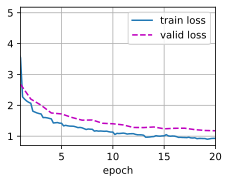

In [ ]:
# devices, num_epochs, lr, wd = d2l.try_all_gpus(), 20, 0.0001, 0.0001
# lr_period, lr_decay, net = 4, 0.9, get_net(devices)

# train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay)

train loss 0.899
128.9 examples/sec on [device(type='cuda', index=0)]


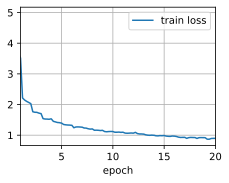

In [ ]:
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 20, 0.0001, 0.0001
lr_period, lr_decay, net = 4, 0.9, get_net(devices)
#net = get_net(devices)
#将所有数据叠加进模型进行重新训练
train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

preds = []
for data, label in test_iter:
    output = torch.nn.functional.softmax(net(data.to(devices[0])), dim=1)
    preds.extend(output.cpu().detach().numpy())
ids = sorted(os.listdir(
    os.path.join(data_dir, 'train_valid_test', 'test', 'unknown')))
with open('submission.csv', 'w') as f:
    f.write('id,' + ','.join(train_valid_ds.classes) + '\n')
    for i, output in zip(ids, preds):
        f.write(i.split('.')[0] + ',' + ','.join(
            [str(num) for num in output]) + '\n')

In [ ]:
#df.to_csv('submission_densenet.csv', index=False)

from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>